In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# generate data
np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
+ 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

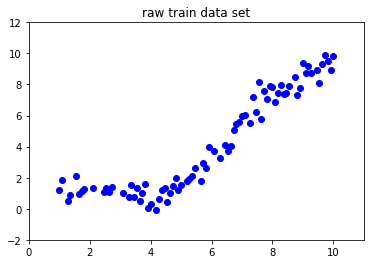

In [206]:
#plot of trainData
plt.plot(trainData, trainTarget, 'bo')
plt.axis([0,11, -2, 12])
plt.title("raw train data set")
plt.show()

In [49]:
def pairwise_dist(x, z):
    z = tf.transpose(z)
    return tf.squared_difference(x, z)

In [103]:
#testing pairwise_dist function
x = tf.constant([[1],[2],[3],[4]])
z = tf.constant([[1],[2],[3]])
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
print(sess.run(pairwise_dist(x,z)))

[[0 1 4]
 [1 0 1]
 [4 1 0]
 [9 4 1]]


In [194]:
def get_respon_mat(m, k):
    #m = tf.transpose(m)
    # get sorted index
    values, indices = tf.nn.top_k(-m, k, sorted=True)
    #indices, dummy = tf.nn.top_k(-indices, k, sorted=True)
    #indices = -indices
    # build up [[1,2], [1,3]] index form
    indices_pair = tf.tile(tf.reshape(tf.range(0, tf.shape(m)[0]), [-1,1]), [1,k])
    concated = tf.concat(2, [tf.reshape(indices_pair, [-1,k,1]), tf.reshape(indices, [-1,k,1])])
    concated = tf.reshape(concated, [-1,2])
    # return dense matrix
    value = 1 / k
    res = tf.sparse_to_dense(sparse_indices=concated, output_shape=[tf.shape(m)[0], tf.shape(m)[1]], \
                               sparse_values=value, validate_indices=False)
    return res

In [198]:
# testing for get_respon_mat function
train = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
test_input = np.linspace(0.0, 11.0, num = 1000)
test_input = np.expand_dims(test_input, axis=0)
test_input = np.transpose(test_input)
r = get_respon_mat(pairwise_dist(X, train), 2)
y_hat = tf.matmul(tf.transpose(target), tf.transpose(r))
sess.run(init)
predict = sess.run(y_hat, feed_dict={X: test_input, train: trainData, target: trainTarget})

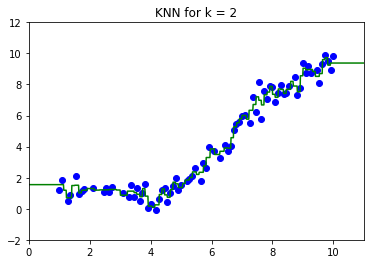

In [208]:
plt.plot(trainData, trainTarget, 'bo', test_input, np.transpose(predict), 'g-')
plt.axis([0,11, -2, 12])
plt.title("KNN for k = 2")
plt.show()

k:  1, trainMSE: 0.00, validMSE: 5.43, testMSE: 6.22


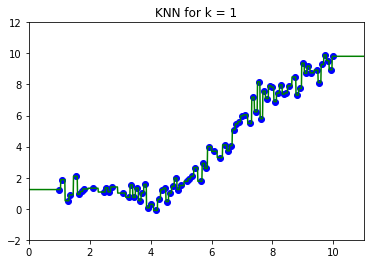

k:  3, trainMSE: 16.84, validMSE: 6.53, testMSE: 2.90


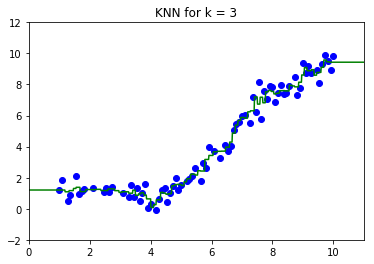

k:  5, trainMSE: 18.97, validMSE: 6.21, testMSE: 3.57


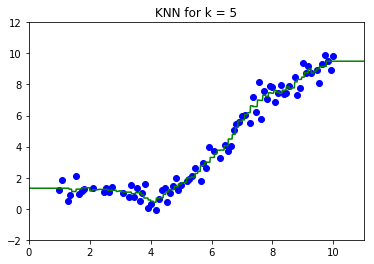

k: 50, trainMSE: 199.68, validMSE: 24.57, testMSE: 14.14


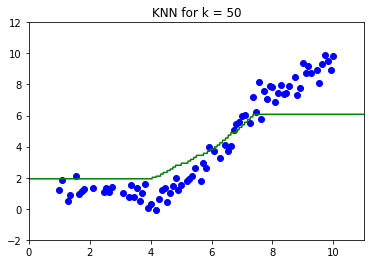

In [250]:
# train model
kList = [1,3,5,50]
train = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
test_input = np.linspace(0.0, 11.0, num = 1000)
test_input = np.expand_dims(test_input, axis=0)
test_input = np.transpose(test_input)
plot_input = tf.constant(test_input)

sess.run(init)
for k in kList:
    # Error definition
    r = get_respon_mat(pairwise_dist(X, train), k)
    y_hat = tf.matmul(tf.transpose(target), tf.transpose(r))
    meanSquaredError = tf.reduce_mean(tf.reduce_sum(tf.square(y_hat - tf.transpose(Y))))
    trainMSE = sess.run(meanSquaredError, feed_dict={X: trainData, Y: trainTarget, train: trainData, target: trainTarget})
    validMSE = sess.run(meanSquaredError, feed_dict={X: validData, Y: validTarget, train: trainData, target: trainTarget})
    testMSE = sess.run(meanSquaredError, feed_dict={X: testData, Y: testTarget, train: trainData, target: trainTarget})
    plot_predict = sess.run(y_hat, feed_dict={X: test_input, train: trainData, target: trainTarget})
    print("k: %2d, trainMSE: %0.2f, validMSE: %0.2f, testMSE: %0.2f"%(k, trainMSE, validMSE, testMSE))
    plt.plot(trainData, trainTarget, 'bo', test_input, np.transpose(plot_predict), 'g-')
    plt.axis([0,11, -2, 12])
    plt.title("KNN for k = %d"%(k))
    plt.show()

In [ ]:
print(trainData)